In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [60]:

c=1.0 # velocidad de la onda
l=1.0 # amplitud de la onda
n=2   # modo normal
v=0.01/np.pi
lr = 1e-3
layers = 5
neuronas = 128
epocs = 8_000 # la mejora parece estar en la cantidad de epocs y no en el grosor ni profundidad de la red

In [61]:
# Modelo ecuacion de onda u(x,t)

class FunAct(nn.Module):
    def forward(self,x):
        return torch.tanh(x)


class MLP(nn.Module):
    def __init__(self, in_dim=2, out_dim=1, width=neuronas, depth=layers):
        super().__init__()
        capas = [nn.Linear(in_dim, width), FunAct()]
        for _ in range(depth - 1):
            capas += [nn.Linear(width, width), FunAct()]
        capas +=[nn.Linear(width, out_dim)]
        self.net=nn.Sequential(*capas)    

    def forward(self, x,t):
        XT = torch.cat([x, t], dim=1)
        return self.net(XT)
        

In [62]:
u = MLP().to(device)

In [63]:
def D(y, x):
    return torch.autograd.grad(y,x, torch.ones_like(y), retain_graph = True, create_graph= True)[0]
def psi(u,x,t):
    
    u_x = D(u,x)
    u_xx = D(u_x,x)

    u_t = D(u,t)
    u_tt = D(u_t,t)

    return u_t + u*u_x -v*u_xx 

In [64]:
### muestreo

N_poblado   = 5000
N_condicion = 200


In [65]:
optimizador = torch.optim.Adam(u.parameters(), lr)

In [66]:
loss_valores = []

for step in range(epocs):

    optimizador.zero_grad()


    t_poblado   = torch.rand((N_poblado, 1), device=device, requires_grad=True)
    x_poblado   = torch.rand((N_poblado, 1), device=device, requires_grad=True)*2 -1 # de -1 a 1

    t_condicion = torch.rand((N_condicion,1), device=device, requires_grad=True)
    x_condicion = torch.rand((N_condicion,1), device=device, requires_grad=True)*2 -1

    ### condiciones de borde
   
    xl = torch.ones_like(x_condicion,  device=device, requires_grad=True)

    ### condiciones iniciales
    t0 = torch.zeros_like(t_condicion, device=device, requires_grad=True)

    residuo = psi(u(x_poblado,t_poblado),x_poblado,t_poblado)
    loss_residuo = (residuo**2).mean()

    u0t = u(-xl,t_condicion) 
    ult = u(xl,t_condicion) 

    loss_cb = (u0t**2).mean() + (ult**2).mean()

    ux0 = u(x_condicion,t0)
    
    fx = -torch.sin(torch.pi*x_condicion)
    

    loss_ci = ((ux0-fx)**2).mean() 
    loss = loss_residuo + loss_cb + loss_ci

    loss_valores.append(loss.item())

    loss.backward()

    optimizador.step()

    if step % 200 == 0:
        print(f"step {step:4d} | loss {loss.item():.3e}")


step    0 | loss 5.410e-01
step  200 | loss 1.489e-01
step  400 | loss 1.004e-01
step  600 | loss 8.057e-02
step  800 | loss 9.445e-02
step 1000 | loss 6.717e-02
step 1200 | loss 4.482e-02
step 1400 | loss 3.070e-02
step 1600 | loss 1.267e-02
step 1800 | loss 1.378e-02
step 2000 | loss 5.771e-03
step 2200 | loss 5.479e-03
step 2400 | loss 6.656e-03
step 2600 | loss 3.207e-03
step 2800 | loss 3.130e-03
step 3000 | loss 3.681e-03
step 3200 | loss 3.114e-03
step 3400 | loss 7.467e-03
step 3600 | loss 2.025e-03
step 3800 | loss 1.908e-03
step 4000 | loss 8.465e-03
step 4200 | loss 1.666e-03
step 4400 | loss 2.682e-03
step 4600 | loss 1.788e-03
step 4800 | loss 1.091e-03
step 5000 | loss 6.524e-03
step 5200 | loss 1.113e-03
step 5400 | loss 3.231e-03
step 5600 | loss 1.020e-02
step 5800 | loss 8.837e-04
step 6000 | loss 2.048e-03
step 6200 | loss 1.098e-03
step 6400 | loss 2.364e-03
step 6600 | loss 1.534e-03
step 6800 | loss 1.243e-03
step 7000 | loss 4.726e-03
step 7200 | loss 3.880e-03
s

Text(0, 0.5, 'Log Loss')

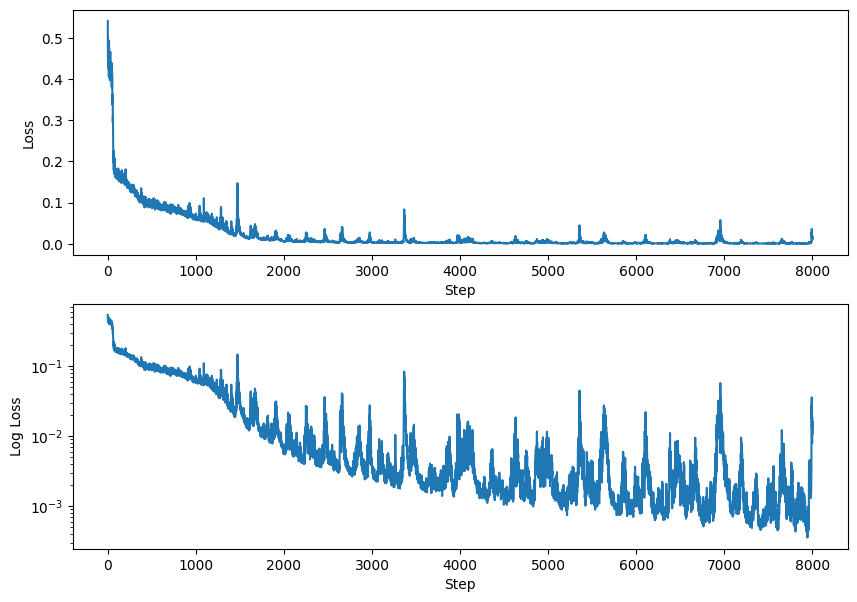

In [67]:
plt.figure(figsize=(10,7))

plt.subplot(2,1,1)
plt.plot(loss_valores)
plt.xlabel("Step"); plt.ylabel('Loss')
plt.subplot(2,1,2)
plt.plot(loss_valores)
plt.yscale('log')  # si baja exponencialmente
plt.xlabel("Step"); plt.ylabel("Log Loss")

Dimensiones: us = 400 x 400
x: -1.000 a 1.000
t: 0.000 a 1.000


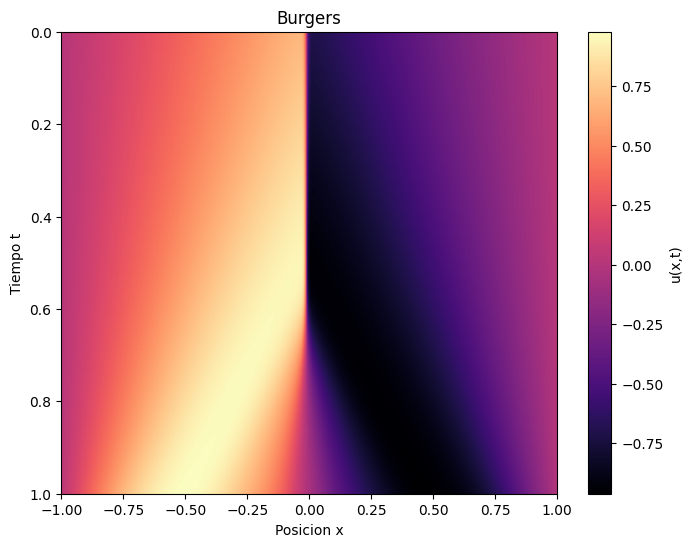

In [72]:
t_max = 1

with torch.no_grad():
    us = []
    xg = torch.linspace(-1.0, float(l), 400, device=device).view(-1, 1)
    
    
    t_range = torch.linspace(0.0, t_max, 400, device=device)  
    
    for i in range(400):
        tg = torch.full_like(xg, t_range[i])  
        
        U = u(xg, tg).squeeze().detach().cpu().numpy()
        us.append(U)
    
    
    x = xg.detach().cpu().numpy().ravel()
    t = t_range.detach().cpu().numpy().ravel()

print(f"Dimensiones: us = {len(us)} x {len(us[0])}")
print(f"x: {x.min():.3f} a {x.max():.3f}")
print(f"t: {t.min():.3f} a {t.max():.3f}")


us_array = np.array(us)  

plt.figure(figsize=(8, 6))
plt.imshow(us_array, 
           extent=[x.min(), x.max(), t.max(), t.min()], 
           aspect='auto', 
           cmap='magma',
           origin='lower')  # t=0 en la parte inferior
plt.colorbar(label='u(x,t)')
plt.xlabel('Posicion x')
plt.ylabel('Tiempo t')
plt.title('Burgers')
plt.show()
plt.show()